In [1]:
#imports
import sys
import subprocess 
import scipy.constants as con
import scipy.optimize as opt
import importlib
#import scipy as sp
import numpy as np
from scipy import special
from scipy import integrate
import scipy.linalg as la
from scipy.optimize import root_scalar
from scipy.integrate._ivp import common as jacpack
import time
import matplotlib.pyplot as plt

import pynucastro as pyna
reaclibrary = pyna.ReacLibLibrary()
from numba import njit

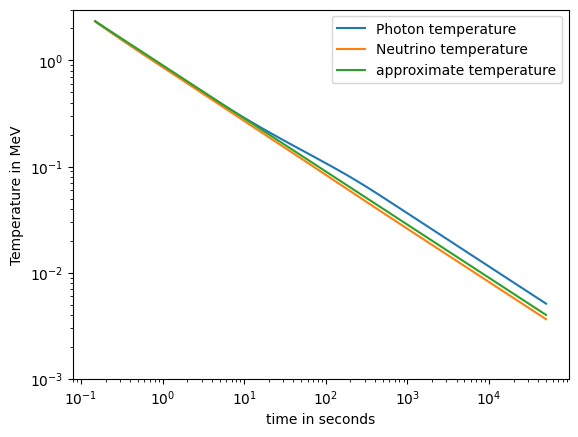

In [2]:
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z


timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 

n_life=879.6*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931.494102          #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.709e-45             #gravatational constant in units of c=hbar=MeV=1
#infapprox=1e3           #large number acting as upper limit on itegrals
n_nu=3.046              #number of neutrino families with correction from 
                        #Nollett and Steigman, BBN and the CMB constrain neutrino coupled light WIMPs, 2015

TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K
cm3s=1.167*10**-11  #conversion factor for cm^3/s
gcm3=232012         #conversion factor for g/cm^3
meter=5.068e12      #conversion factor for m
cm=5.068e10         #conversion factor for cm
barn=389.4          #conversion factor for barn
e_mass=0.51099895   #electron mass in MeV


def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1))))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)])


def P_e(T): #electron/positron pressure
    z=e_mass/T
    '''
    func=lambda x: 2/(3*np.pi**2)*e_mass**4*((x**4*(x**2+1)**-0.5)/((np.exp(z*(x**2+1)**0.5)+1)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    #Fowler and Hoyle 1964
    #return 4/np.pi**2*T**4*np.sum([(-1)**(n+1)/n**4*special.kn(2,n*z) for n in range(1,10)])
    
    #Kawano
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,10)])  



def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3



### Initial conditions ###

T_ini=27/TMeV2T9                     #initial temperature in MeV

t_ini=1.226*10**21/T_ini**2 #initial time in hbar/MeV


z_ini=e_mass/T_ini

n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701*T_ini) #initial number density of photons based mean photon energy



rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density


rho_tot_ini=rho_e(T_ini)+rho_gamma(T_ini)+rho_nu_ini#+rho_b_ini  #initial total energy density

H_ini=np.sqrt(8*np.pi/3*G*rho_tot_ini)


def rho_nu(T,a): #neutrina energy density
    #return 7/8*np.pi**2/15*T**4
    return rho_nu_ini/a**4




#def P_b(T,h):
#    return h*T**4*2/3*

#Phie_ini=np.pi**2/2*con.Avogadro*h_ini/z_ini**3*1/sum([(-1)**(n+1)*n*L(n*z_ini) for n in range(1,20)]) 




### Solving the background ###

def rho_tot(T,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(T,a)#+rho_b(a)

def rho_set(T,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)#+rho_b(a)

def H(T,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,a))

#Derivative from Kavano D.18
def dTdt(t,T,a):
    return -3*H(T,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))

#Derivative from Kavano D.19
def dhdt(t,T,h,a):
    return -3*h*(H(T,h,a)+dTdt(t,T,h,a)/T)

#Derivative from how H is defined
def dadt(t,T,a):
    return a*H(T,a)


t_range=[t_ini,5e4*timeunit]            #time range for integration
#t_space=np.linspace(*t_range,1000)      #time range for approximate temperature

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = a
    return [dTdt(t,*y),dadt(t,*y)]

# Solving it
sol = integrate.solve_ivp(dbackground, t_range, [T_ini,1],method='Radau',atol=1e-80,rtol=1e-6,t_eval=np.geomspace(*t_range,10000))#,t_eval=t_space)

plt.figure()
# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Photon temperature')

# Test with completely radiation dominated universe
t_space=sol.t
T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(t_space/timeunit, T_ini/sol.y[1], label='Neutrino temperature')

plt.plot(t_space/timeunit, T_approx, label='approximate temperature')
#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()

#plt.figure

Tsqr=sol.y[0]**-2
asqrt=sol.y[1]**2

n_bparams=2

solt=sol.t

@njit
def T_cache(t):   #solve h and T, y[0] = T, y[1] = a
    return 1/np.sqrt(np.interp(t,solt,Tsqr))
    #return -np.interp(t,sol.t,-sol.y[0])
    #return -interp1d(sol.t,-sol.y[0], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)

@njit
def a_cache(t):
    return np.sqrt(np.interp(t,solt,asqrt))
    #return np.interp(t,sol.t,sol.y[1])
    #return interp1d(sol.t,sol.y[1], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)



In [3]:
#import networks

#section for AoT compilation of network
#import H2_AoT_net as bbn_H2
#import He4_AoT_net as bbn_He4
'''
import AoT_net as bbn_n
import full_AoT_net as bbn_full

#Jit compilation
import full_size_net as bbn_full

networks=[bbn_n,bbn_full]
#number of nuclei in network, nNucs[-1]=2 to since initial condition sets n and p
nNucs=[net.nnuc() for net in networks]+[2]
'''

#Jit compilation
import bbn_test_integrate as bbn_n
#import full_size_net as bbn_full
import Newrate_net as bbn_full
networks=[bbn_n,bbn_full]
nNucs=[net.nnuc for net in networks]+[2]


#compile rhs and Jacobians
for i in range(len(networks)):
    prev_time=time.time()
    networks[i].rhs(float(1000), np.ones(nNucs[i]),0.00001, float(1e7))
    print(str(i+1)+f'. rhs compiled in {time.time()-prev_time:.2f} seconds')
    prev_time=time.time()
    networks[i].jacobian(float(1000), np.ones(nNucs[i]),0.00001, float(1e7))
    print(str(i+1)+f'. jacobian compiled in {time.time()-prev_time:.2f} seconds')


#times for switching between networks
t_start=[t_ini,timeunit,1e5*timeunit]



1. rhs compiled in 13.69 seconds
1. jacobian compiled in 12.25 seconds
2. rhs compiled in 45.49 seconds
2. jacobian compiled in 47.53 seconds


In [4]:
prev_time=time.time()
T_cache(1.1)

a_cache(1.1)
print(f'Background interpolation compiled in {time.time()-prev_time:.2f} seconds')

Background interpolation compiled in 0.28 seconds


In [5]:
#Setup isotopes based on Alterbbn
Y_labels=['n','p','H2','H3','He3','He4','Li6','Li7','Li8','Be7','Be9','B8','B10','B11','B12','C11','C12','C13','C14','N12','N13','N14','N15','O14','O15','O16']
Alter_Yl=["n","p","H2","H3","He3","He4","Li6","Li7","Be7","Li8","B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]

fnNucs=nNucs[-2]

A=np.array([1,1,2,3,3,4,6,7,8,7,9,8,10,11,12,11,12,13,14,12,13,14,15,14,15,16])
Alter_A=[1.,1.,2.,3.,3.,4.,6.,7.,7.,8.,8.,9.,10.,11.,11.,12.,12.,12.,13.,13.,14.,14.,14.,15.,15.,16.]

Z=sorted([0,1,1,1,2,2,3,3,4,3,5,4,5,5,6,5,6,7,6,7,6,7,8,7,8,8.])
Alter_Z=[0.,1.,1.,1.,2.,2.,3.,3.,4.,3.,5.,4.,5.,5.,6.,5.,6.,7.,6.,7.,6.,7.,8.,7.,8.,8.]

def Altersort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])])
#print([label for _, label in sorted(zip(A, Y_labels))])

def PNAsort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])])    


Alterspin=[0.5,0.5,1.,0.5,0.5,0.,1.,1.5,1.5,2.,2.,1.5,3.,1.5,1.5,1.,0.,1.,0.5,0.5,0.,1.,0.,0.5,0.5,0.]
spin=PNAsort(Alterspin)

Alter_mass_excess=[8.071388,7.289028,13.135825,14.949915,14.931325,2.424931,14.0864,14.9078,15.7696,20.9464,22.9212,11.34758,12.05086,8.6680,10.6506,13.3690,0.,17.3382,3.125036,5.3455,3.019916,2.863440,8.006521,0.101439,2.8554,-4.737036]
Alter_mass=[Alter_A[i]*M_u+Alter_mass_excess[i] for i in range(fnNucs)]
m_Nucs = np.array(PNAsort(Alter_mass))
m_n,m_p,m_d,m_t,m_He3,m_He4=m_Nucs[:6]




B=[(m_Nucs[1]*Z[i]+m_Nucs[0]*(A[i]-Z[i]))-m_Nucs[i] for i in range(fnNucs)]
g = 1+2*np.array(spin)

print(Alter_Yl)
print(Altersort(Y_labels))

print(Y_labels)
print(PNAsort(Alter_Yl))

['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Be7', 'Li8', 'B8', 'Be9', 'B10', 'B11', 'C11', 'B12', 'C12', 'N12', 'C13', 'N13', 'C14', 'N14', 'O14', 'N15', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Be7', 'Li8', 'B8', 'Be9', 'B10', 'B11', 'C11', 'B12', 'C12', 'N12', 'C13', 'N13', 'C14', 'N14', 'O14', 'N15', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Li8', 'Be7', 'Be9', 'B8', 'B10', 'B11', 'B12', 'C11', 'C12', 'C13', 'C14', 'N12', 'N13', 'N14', 'N15', 'O14', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Li8', 'Be7', 'Be9', 'B8', 'B10', 'B11', 'B12', 'C11', 'C12', 'C13', 'C14', 'N12', 'N13', 'N14', 'N15', 'O14', 'O15', 'O16']


In [6]:
#Functions for determining additional abundances for each network

#Initial conditions from thermal equilibrium
def get_Y_thermal(Y,n,T):
    eta_ini=6.1e-10
    Y_2 = np.zeros(n)
    Y_2[:len(Y)] = Y
    for i in range(len(Y),n):
        tmp = special.zeta(3)**(A[i] - 1)*np.pi**((1 - A[i])/2)*2**((3*A[i] - 5)/2)*A[i]**(5/2)
        Y_2[i] = g[i]*tmp*(T/m_n)**(3*(A[i] - 1)/2)*eta_ini**(A[i] - 1)*Y[1]**Z[i]*Y[0]**(A[i] - Z[i])*np.exp(B[i]/T)/A[i]

    return Y_2

def solve_using_svd(U, s, Vh, b):
    bb = U.T @ b
    y = bb/s
    x = Vh.T @ y
    return x

etaratio=1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))

def rho_bY_cgs(y,eta=6.1e-10):
    return np.dot(y[n_bparams:6+n_bparams],m_Nucs[:6])*eta*etaratio*n_gamma_ini/y[1]**3*gcm3


#Initial conditions from Jacobian
def get_Y_jac(y,i):

    AdYdt_cut=lambda Y : Altersort(networks[i].rhs(0.1, PNAsort(Y) ,rho_bY_cgs(list(y[:n_bparams])+list(PNAsort(Y))), y[0]*TMeV2T9*1e9))
    AdYdt_jac_cut=lambda Y : networks[i].jacobian(0.1, PNAsort(Y) ,rho_bY_cgs(list(y[:n_bparams])+list(PNAsort(Y))), y[0]*TMeV2T9*1e9)[:, Altersort(range(nNucs[i]))][Altersort(range(nNucs[i]))]
    aY_cut=Altersort(get_Y_thermal(y[n_bparams:][:nNucs[i-1]],nNucs[i],y[0]))

    Yj = np.array([YY for YY in aY_cut])
    
    
    for cut in range(nNucs[i-1], len(Yj) - 2, 1):
        for j in range(10):
            fyj = -AdYdt_cut(Yj)
            jac = AdYdt_jac_cut(Yj)
            if np.any(np.isnan(Yj)) or np.any(np.isinf(Yj)):
                print('Yj:', Yj)
                raise ValueError
            if np.any(np.isnan(fyj)) or np.any(np.isinf(fyj)):
                print('Yj:', Yj)
                print('fyj:', fyj)
                raise ValueError
            # Implement cut:
            fyj = fyj[cut:]
            jac = jac[cut:, cut:]
            
            # Solution using SVD
            U, s, Vh = la.svd(jac)    
            x = solve_using_svd(U, s, Vh, fyj)
            for k in range(1):
                #A · δx = A · (x + δx) − b
                residuals = jac @ x - fyj
                dx = solve_using_svd(U, s, Vh, residuals)
                x -= dx
            Yj[cut:] += x
    return list(PNAsort(Yj))

In [7]:
#Solve the system
#initial conditions




etaL=sorted(np.append(np.linspace(5.6e-10,6.8e-10,100),np.linspace(5.9e-10,6.1e-10,100)))
#etaL=[6.1e-10]
Dabun=[]
for eta in etaL:
    solY=np.array([[1/(np.exp(Q/T_ini)+1)],[1/(np.exp(-Q/T_ini)+1)]])
    soltime=np.array([t_ini])

    for i in range(len(networks)):
        initial_param=get_Y_jac(np.array([T_cache(t_start[i]),a_cache(t_start[i])]+list(solY[:,-1])),i)

        #Give PyNucAstro jacobian nessecary parameters
        def jacPNA(t,Y):
            y=np.array([T_cache(t+t_start[i]),a_cache(t+t_start[i])]+list(Y))
            jac=networks[i].jacobian(t/timeunit, Y,rho_bY_cgs(y,eta), y[0]*TMeV2T9*1e9)/timeunit
            return jac
        

        #full derivative
        def dydt(t,Y): 
            y=np.array([T_cache(t+t_start[i]),a_cache(t+t_start[i])]+list(Y))
            result=list( networks[i].rhs(t/timeunit, Y,rho_bY_cgs(y,eta), y[0]*TMeV2T9*1e9)/timeunit)      

            return result
        
        jacsolY = integrate.solve_ivp(dydt, [0,t_start[i+1]-t_start[i]], initial_param,method='Radau',atol=1e-80,rtol=1e-6,jac=jacPNA,first_step=timeunit*1e-3)#,t_eval=t_space)

        abun=[abun[-1] for abun in jacsolY.y]
    
        
        
        solY=np.concatenate((np.concatenate((solY,np.multiply(np.ones((len(solY[0]),nNucs[i]-nNucs[i-1])),initial_param[len(solY):]).T)),jacsolY.y),axis=1)

        soltime=np.concatenate((soltime,jacsolY.t+t_start[i]))
    Dabun+=[abun[2]/abun[1]]



In [8]:
final_abun=[fabun[-1] for fabun in solY]


print([final_abun[0],final_abun[1],2*final_abun[2],3*final_abun[3],3*final_abun[4],4*final_abun[5]])
print('sum: ', sum(np.array(final_abun)*A[:fnNucs]))

[5.0745881198750867e-11, 0.7516297482932823, 3.071661780711507e-05, 1.4901328618465706e-07, 2.2478655854092122e-05, 0.24831690405570567]
sum:  1.0000000000020883


In [9]:
print(' ')
print('Results from this code')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')
abun=final_abun
print('value:\t '"{:.3e}".format(4*abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))


 
Results from this code
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.483e-01	 2.043e-05	 1.003e-05	 6.301e-10	 6.119e-15	 6.038e-10


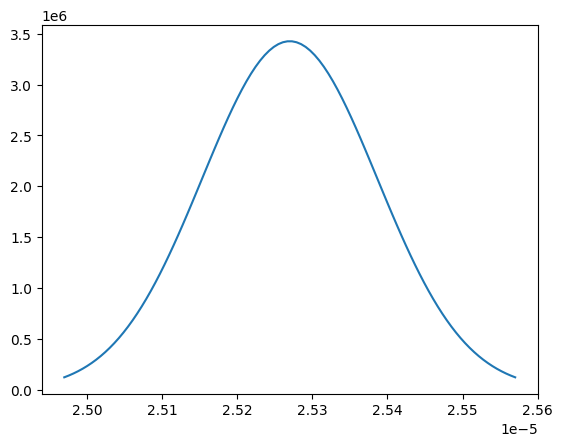

In [10]:
def gauss(x, mu, sig):
    return 1/(np.sqrt(2*np.pi)*sig)*np.exp(-((x-mu)/sig)**2/2)

import scipy.optimize as opt
sigma=opt.fsolve(lambda sig: integrate.quad(gauss,2.497e-5, 2.557e-5, args=(2.527e-5,sig))[0]-0.99,x0=1e-5)[0]

x=np.linspace(2.497e-5,2.557e-5,100)
plt.plot(x,gauss(x,2.527e-5,sigma))

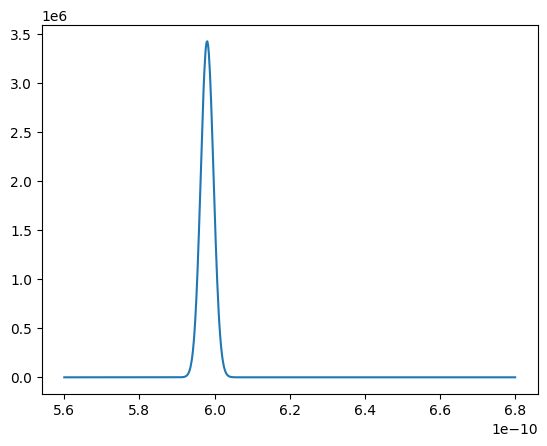

In [15]:
plt.figure()
plt.plot(etaL,gauss( np.array(Dabun) ,2.527e-5,sigma))
#plt.plot(etaL,gauss( np.array(Dabun) ,2.527e-5,sigma))

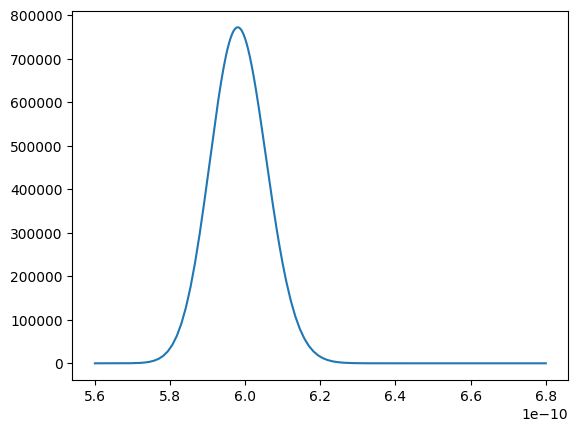

In [12]:
plt.figure()
plt.plot(etaL,gauss(np.array(Dabun),2.527e-5,sigma+4e-7))

In [13]:
eee=0
for i in range(200):
    if gauss(np.array(Dabun[eee]),2.527e-5,sigma+4e-7)<gauss(np.array(Dabun[i]),2.527e-5,sigma+4e-7):
        eee=i
etaL[eee]

5.980808080808081e-10

In [14]:
Dabun

[2.811250619886969e-05,
 2.8014529851912227e-05,
 2.791707363239812e-05,
 2.782012910813865e-05,
 2.7723698136166582e-05,
 2.7627780454105685e-05,
 2.7532363391961037e-05,
 2.7437444506560935e-05,
 2.734302602805144e-05,
 2.724909401696246e-05,
 2.7155655547266275e-05,
 2.7062702056844554e-05,
 2.6970231375152593e-05,
 2.687823699447655e-05,
 2.6786718234260475e-05,
 2.6695670298552975e-05,
 2.6605090715753872e-05,
 2.651497528614872e-05,
 2.642531843563069e-05,
 2.633612227281461e-05,
 2.6247378376745525e-05,
 2.6159087556284964e-05,
 2.607124207793974e-05,
 2.5983840922136448e-05,
 2.5896879786433217e-05,
 2.5831948379773765e-05,
 2.5817549824740706e-05,
 2.5810356085847446e-05,
 2.5803165570425063e-05,
 2.578879382025883e-05,
 2.5774433685212736e-05,
 2.5760086940618517e-05,
 2.5745752290755916e-05,
 2.5731428415874145e-05,
 2.5724270836377867e-05,
 2.5717116528960294e-05,
 2.5702816452565155e-05,
 2.568852854276144e-05,
 2.5674252690113258e-05,
 2.5659988021717043e-05,
 2.564573611